In [11]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.widgets import Cursor
from scipy.optimize import curve_fit
from scipy.optimize import differential_evolution
from sympy import *
plt.rcParams.update({'font.size': 12})
formatter = mticker.ScalarFormatter(useMathText=True)
plt.rcParams["axes.formatter.use_mathtext"] = True

In [12]:
dir_name_20 = './Dados/amarelo/20/'
dir_name_40 = './Dados/amarelo/40/'
dir_name_60 = './Dados/amarelo/60/'
dir_name_80 = './Dados/amarelo/80/'
dir_name_100 = './Dados/amarelo/100/'
dir_name_color = './Dados/amarelo/'

In [13]:
def list_dir(dir_name, traversed = [], results = []): 
    dirs = os.listdir(dir_name)
    if dirs:
        for f in dirs:
            new_dir = dir_name + f + '/'
            if os.path.isdir(new_dir) and new_dir not in traversed:
                traversed.append(new_dir)
                list_dir(new_dir, traversed, results)
            else:
                results.append(new_dir[:-1])  
    return results

def arquivos_lista(dir_name):
    arquivos_lista = []
    for file_name in list_dir(dir_name):
           arquivos_lista.append(file_name) # sample with file size
    return arquivos_lista


def dados(arquivos_lista):
    arquivos = []
    for arquivo in arquivos_lista:
       df = pd.read_csv(arquivo, sep=";", decimal = ',')
       dados_array = np.array(df)
       arquivos.append(dados_array)
    return arquivos

def func(x, A, B):
    return A*x + B

def metodo1(diretorio):
    dados_teste = dados(arquivos_lista(diretorio))
    x_data = []
    y_data = []
    valores_V0_array = []
    for i in range(len(dados_teste)):
        ax = []
        ay = []
        for dado in dados_teste[i]:
            ax.append(dado[0])
            ay.append(dado[1])
        x_data.append(ax)
        y_data.append(ay)

    for i in range(len(x_data)):
        metodo1_x = []
        metodo1_y = []
        for j in range(len(x_data[i])):
            if y_data[i][j] > 0:
                metodo1_y.append(y_data[i][j-2])
                metodo1_y.append(y_data[i][j-1])
                metodo1_y.append(y_data[i][j])
                metodo1_y.append(y_data[i][j+1])

                metodo1_x.append(x_data[i][j-2])    
                metodo1_x.append(x_data[i][j-1])    
                metodo1_x.append(x_data[i][j])    
                metodo1_x.append(x_data[i][j+1])    
                break
        popt, pcov = curve_fit(
            f = func,
            xdata = metodo1_x,
            ydata = metodo1_y
        )

        par = popt
        perr = np.sqrt(np.diag(pcov))

        V0 = -par[1]/par[0]
        sV0 = -V0*np.sqrt(perr[1]**2/par[1]**2 + perr[0]**2/par[0]**2)
        valores_V0_array.append([V0, sV0])

    valores_V0_df = pd.DataFrame(valores_V0_array)
    return valores_V0_df.mean()

def metodo2(diretorio):
    dados_teste = dados(arquivos_lista(diretorio))
    x_data = []
    y_data = []
    valores_V0_array = []
    for i in range(len(dados_teste)):
        ax = []
        ay = []
        for dado in dados_teste[i]:
            ax.append(dado[0])
            ay.append(dado[1])
        x_data.append(ax)
        y_data.append(ay)
        
    for i in range(len(x_data)):
        x_data_p = []
        y_data_p = []
        x_data_n = []
        y_data_n = []
        for j in range(len(x_data[i])):
            # if dado[1] < 0:
            if y_data[i][j] < 0:
                x_data_n.append(x_data[i][j])
                y_data_n.append(y_data[i][j])
            # elif dado[1] > 2e-8 and dado[0] <= 0:
            elif y_data[i][j] > 2e-8 and x_data[i][j] < 0:
                x_data_p.append(x_data[i][j])
                y_data_p.append(y_data[i][j])
        popt_p, pcov_p = curve_fit(
            f = func,
            xdata = x_data_p,
            ydata = y_data_p
        )
        par_p = popt_p
        perr_p = np.sqrt(np.diag(pcov_p))
        
        popt_n, pcov_n = curve_fit(
            f = func,
            xdata = x_data_n,
            ydata = y_data_n
        )
        par_n = popt_n
        perr_n = np.sqrt(np.diag(pcov_n))
        
        V0 = (par_p[1] - par_n[1])/(par_n[0]- par_p[0])
        sV0 = -V0*np.sqrt((perr_p[1]**2 + perr_n[1]**2)/(par_p[1] - par_n[1])**2 + (perr_p[0]**2 + perr_n[0]**2)/(par_p[0] - par_n[0])**2)
                
        valores_V0_array.append([V0, sV0])
        valores_V0_df = pd.DataFrame(valores_V0_array)
    return valores_V0_df.mean()

def metodo4(diretorio):
    dados_teste = dados(arquivos_lista(diretorio))
    x_data = []
    y_data = []
    valores_V0_array = []
    for i in range(len(dados_teste)):
        ax = []
        ay = []
        for dado in dados_teste[i]:
            ax.append(dado[0])
            ay.append(dado[1])
        x_data.append(ax)
        y_data.append(ay)
        
    for i in range(len(x_data)):
        d2y_data = []
        d2x_data = []
        for j in range(len(x_data[i])):
            # if dado[1] < 0:
            if j > 1 and j < len(x_data[i]) - 2:
                derivada = (y_data[i][j+2]+ y_data[i][j-2] - 2*y_data[i][j])/(x_data[i][j+1] - x_data[i][j-1])**2
                d2y_data.append(derivada)
                d2x_data.append(x_data[i][j])

        for j in range(len(d2x_data)):
            if d2y_data[j] > 0 and d2y_data[j+1] > d2y_data[j] and d2y_data[j+2] > d2y_data[j+1] and d2y_data[j+3] > d2y_data[j+2]:
                V0 = d2x_data[j]
                valores_V0_array.append(V0)
                break
        
        valores_V0_df = pd.DataFrame(valores_V0_array)
    return [valores_V0_df.mean(), valores_V0_df.std()]

metodo4(dir_name_40)



# valores_V0 = [metodo1(dir_name_40)[0], metodo1(dir_name_60)[0], metodo1(dir_name_80)[0], metodo1(dir_name_100)[0]]
# sV0 = np.sqrt((metodo1(dir_name_40)[1]**2 + metodo1(dir_name_60)[1]**2 +  metodo1(dir_name_80)[1]**2 + metodo1(dir_name_100)[1]**2))/4
# valores_V0 = pd.DataFrame(valores_V0)

# valores_V0_2 = [metodo2(dir_name_40)[0], metodo2(dir_name_60)[0], metodo2(dir_name_80)[0], metodo2(dir_name_100)[0]]
# sV0_2 = np.sqrt((metodo2(dir_name_40)[1]**2 + metodo2(dir_name_60)[1]**2 +  metodo2(dir_name_80)[1]**2 + metodo2(dir_name_100)[1]**2))/4
# valores_V0_2 = pd.DataFrame(valores_V0_2)

valores_V0_4 = [metodo4(dir_name_40)[0], metodo4(dir_name_60)[0], metodo4(dir_name_80)[0], metodo4(dir_name_100)[0]]
sV0_4 = np.sqrt((metodo4(dir_name_40)[1]**2 + metodo4(dir_name_60)[1]**2 +  metodo4(dir_name_80)[1]**2 + metodo4(dir_name_100)[1]**2))/4
valores_V0_4 = pd.DataFrame(valores_V0_4)




In [14]:
# float(valores_V0.mean()), sV0

In [15]:
# float(valores_V0_2.mean()), sV0_2

In [16]:
float(valores_V0_4.mean()), float(sV0_4)

(-0.8688125, 0.09919962500366461)

In [17]:
dados_teste = dados(arquivos_lista(dir_name_40))[0]
x_data_1 = []
y_data_1 = []
valores_V0_array = []
for dado in dados_teste:
    x_data_1.append(dado[0])
    y_data_1.append(dado[1])
metodo1_x = []
metodo1_y = []
for i in range(len(x_data_1)):
    if y_data_1[i]> 0:
        metodo1_y.append(y_data_1[i-2])
        metodo1_y.append(y_data_1[i-1])
        metodo1_y.append(y_data_1[i])
        metodo1_y.append(y_data_1[i+1])
        metodo1_x.append(x_data_1[i-2])    
        metodo1_x.append(x_data_1[i-1])    
        metodo1_x.append(x_data_1[i])    
        metodo1_x.append(x_data_1[i+1])  
        break
    
popt, pcov = curve_fit(
    f = func,
    xdata = metodo1_x,
    ydata = metodo1_y
)
par_1 = popt
perr_1 = np.sqrt(np.diag(pcov))
V0_1 = -par_1[1]/par_1[0]

x_model_1 = np.array(metodo1_x)
y_model_1= func(x_model_1, par_1[0], par_1[1])

V0_1

-0.9538933490811462

Método 2


In [18]:
dados_teste = dados(arquivos_lista(dir_name_40))[0]
x_data_2 = []
y_data_2 = []
for dado in dados_teste:
    x_data_2.append(dado[0])
    y_data_2.append(dado[1])


In [19]:
dados_teste = dados(arquivos_lista(dir_name_40))[0]
x_data_p = []
y_data_p = []
x_data_n = []
y_data_n = []

for dado in dados_teste:
    if dado[1] < 0:
        x_data_n.append(dado[0])
        y_data_n.append(dado[1])
    elif dado[1] > 2e-8 and dado[0] <= 0:
        x_data_p.append(dado[0])
        y_data_p.append(dado[1])

popt_p, pcov_p = curve_fit(
    f = func,
    xdata = x_data_p,
    ydata = y_data_p
)
par_p = popt_p
perr_p = np.sqrt(np.diag(pcov_p))

popt_n, pcov_n = curve_fit(
    f = func,
    xdata = x_data_n,
    ydata = y_data_n
)
par_n = popt_n
perr_n = np.sqrt(np.diag(pcov_n))


x_model_p = np.linspace(-0.5, max(x_data_p))  
y_model_p = func(x_model_p, par_p[0], par_p[1])

x_model_n = np.linspace(min(x_data_n), 0)  
y_model_n = func(x_model_n, par_n[0], par_n[1])

x_encontro = (par_p[1] - par_n[1])/(par_n[0]- par_p[0])


In [20]:
list_dir(dir_name_color)

['./Dados/amarelo/40/6.csv',
 './Dados/amarelo/40/7.csv',
 './Dados/amarelo/40/5.csv',
 './Dados/amarelo/40/4.csv',
 './Dados/amarelo/40/1.csv',
 './Dados/amarelo/40/3.csv',
 './Dados/amarelo/40/2.csv',
 './Dados/amarelo/40/10.csv',
 './Dados/amarelo/40/9.csv',
 './Dados/amarelo/40/8.csv',
 './Dados/amarelo/40/6.csv',
 './Dados/amarelo/40/7.csv',
 './Dados/amarelo/40/5.csv',
 './Dados/amarelo/40/4.csv',
 './Dados/amarelo/40/1.csv',
 './Dados/amarelo/40/3.csv',
 './Dados/amarelo/40/2.csv',
 './Dados/amarelo/40/10.csv',
 './Dados/amarelo/40/9.csv',
 './Dados/amarelo/40/8.csv',
 './Dados/amarelo/60/6.csv',
 './Dados/amarelo/60/7.csv',
 './Dados/amarelo/60/5.csv',
 './Dados/amarelo/60/4.csv',
 './Dados/amarelo/60/1.csv',
 './Dados/amarelo/60/3.csv',
 './Dados/amarelo/60/2.csv',
 './Dados/amarelo/60/10.csv',
 './Dados/amarelo/60/9.csv',
 './Dados/amarelo/60/8.csv',
 './Dados/amarelo/80/6.csv',
 './Dados/amarelo/80/7.csv',
 './Dados/amarelo/80/5.csv',
 './Dados/amarelo/80/4.csv',
 './Dados/a

In [25]:
def list_dir(dir_name, traversed = [], results = []): 
    dirs = os.listdir(dir_name)
    if dirs:
        for f in dirs:
            new_dir = dir_name + f + '/'
            if os.path.isdir(new_dir) and new_dir not in traversed:
                traversed.append(new_dir)
                list_dir(new_dir, traversed, results)
            else:
                results.append(new_dir[:-1])
    return results

def arquivos_dados(dir_name):
    dados = {
        'dados_20': [],
        'dados_40': [],
        'dados_60': [],
        'dados_80': [],
        'dados_100': []
    }
    for file_name in list_dir(dir_name):
        df = pd.read_csv(file_name, sep=";", decimal = ',')
        dados_array = np.array(df)
        x_data = []
        y_data = []
        for dado in dados_array:
            x_data.append(dado[0])
            y_data.append(dado[1])
        data = {'x_data': x_data,
                'y_data': y_data
                }
        if file_name.find('/20/'):
            dados['dados_20'].append(data)
        if file_name.find('/40/'):
            dados['dados_40'].append(data)
        if file_name.find('/60/'):
            dados['dados_60'].append(data)
        if file_name.find('/80/'):
            dados['dados_80'].append(data)
        if file_name.find('100/'):
            dados['dados_100'].append(data)
    return dados

teste = arquivos_dados(dir_name_color)

In [33]:
y_medio = []
for i in range(len(teste['dados_20'])):
    soma_y = 0
    for j in range(len(teste['data_20'][i])):
        teste['dados_20'][i]['y_data'][0]

-2.724988e-10

Método 3

In [34]:

dados_teste = dados(arquivos_lista(dir_name_color))
x_data = []
y_data = []
data_dict = [x_data, y_data]

for conjunto in dados_teste:
    for dado in conjunto:
        data_dict['x_data'].append(dado)

Método 4


In [35]:
dados_teste = dados(arquivos_lista(dir_name_40))[0]
x_data = []
y_data = []
for dado in dados_teste:
    x_data.append(dado[0])
    y_data.append(dado[1])

d2y_data = []
d2x_data = []
for i in range(len(x_data)):
    if i > 1 and i < len(x_data) - 2:
        derivada = (y_data[i+2]+ y_data[i-2] - 2*y_data[i])/(x_data[i+1] - x_data[i-1])**2
        d2y_data.append(derivada)
        d2x_data.append(x_data[i])

x_data_reta = []
y_data_reta = []
for i in range(len(x_data)):
    if x_data[i] >= -4 and x_data[i] <= -1.5:
        x_data_reta.append(x_data[i])
        y_data_reta.append(y_data[i])

popt, pcov = curve_fit(
    f = func,
    xdata = x_data_reta,
    ydata = y_data_reta
)
par_reta = popt
perr_reta = np.sqrt(np.diag(pcov))


x_model_reta = np.linspace(min(x_data_reta), max(x_data_reta) + 1)  
y_model_reta = func(x_model_reta, par_reta[0], par_reta[1])

def y_sigma(x):
    return (par_reta[0] + perr_reta[0])*x + par_reta[1] + perr_reta[1]

y_sigma_array = []
x_sigma_array = np.linspace(min(x_data), max(x_data))

for i in range(len(x_sigma_array)):
    y_sigma_array.append(y_sigma(x_sigma_array[i]))

for i in range(len(d2x_data)):
    if d2y_data[i] > 0 and d2y_data[i+1] > d2y_data[i] and d2y_data[i+2] > d2y_data[i+1] and d2y_data[i+3] > d2y_data[i+2]:
        V0 = d2x_data[i]
        print(d2y_data[i])
        break
V0

1.2146469999999962e-10


-0.9

Gráficos


G - Método 1


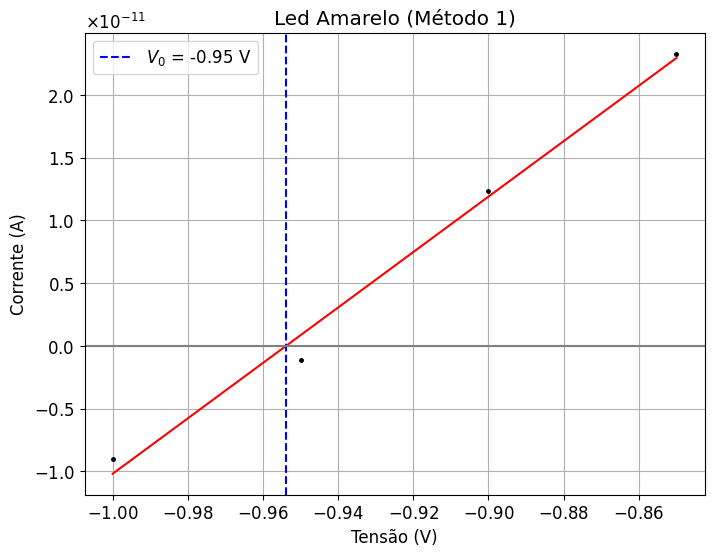

In [36]:
graphWidth = 800
graphHeight = 600

f = plt.figure(figsize=(graphWidth/100.0, graphHeight/100.0), dpi=100)
grafico = f.add_subplot(111)
# plot dos pontos:
grafico3 = grafico.plot(metodo1_x, metodo1_y, marker = '.', markersize=5, color = 'black', linewidth = 0)


# plot(dir_name_40, 'black')
# plot(dir_name_40, 'green')
# plot(dir_name_60, 'blue')
# plot(dir_name_100, 'red')


# plot do ajuste
grafico.plot(x_model_1, y_model_1,  color = 'red')


grafico.axvline(x = V0_1, color = 'blue', label = f'$V_0$ = {V0_1: .2} V', linestyle = '--')
grafico.axhline(y = 0, color = 'grey')



grafico.grid(True)
grafico.set_xlabel('Tensão (V)') # eixo x
grafico.set_ylabel('Corrente (A)') # eixo y
grafico.set_title('Led Amarelo (Método 1)') #título
grafico.legend(loc = 'upper left', fontsize= 12)


#    plt.savefig('Acr25graus.png')
plt.show()


G - Método 2

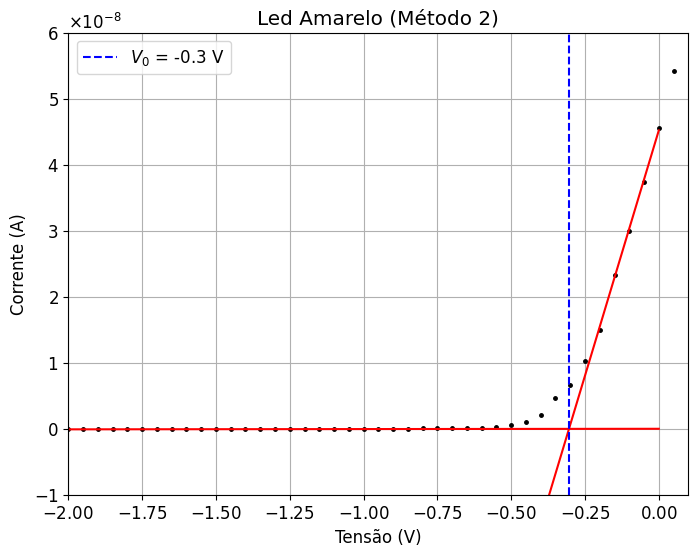

In [37]:

graphWidth = 800
graphHeight = 600

f = plt.figure(figsize=(graphWidth/100.0, graphHeight/100.0), dpi=100)
grafico = f.add_subplot(111)
# plot dos pontos:
grafico3 = grafico.plot(x_data_2, y_data_2, marker = '.', markersize=5, color = 'black', linewidth = 0)
# grafico3 = grafico.plot(x_data_p, y_data_p, marker = '.', markersize=4, color = 'black', linewidth = 0)

# plot(dir_name_40, 'black')
# plot(dir_name_40, 'green')
# plot(dir_name_60, 'blue')
# plot(dir_name_100, 'red')


# plot do ajuste
grafico.plot(x_model_n, y_model_n,  color = 'red')
grafico.plot(x_model_p, y_model_p,  color = 'red')

grafico.axvline(x = x_encontro, color = 'blue', label = f'$V_0$ = {x_encontro: .2} V', linestyle = '--')
# grafico.axvline(x = 0, color = 'grey')
# grafico.axhline(y = 0, color = 'grey')


grafico.grid(True)
grafico.set_xlabel('Tensão (V)') # eixo x
grafico.set_ylabel('Corrente (A)') # eixo y
grafico.set_title('Led Amarelo (Método 2)') #título
grafico.legend(loc = 'upper left', fontsize= 12)

plt.xlim(-2, 0.1)
plt.ylim(-10e-9, 6e-8)

#    plt.savefig('Acr25graus.png')
plt.show()


G - Método 3

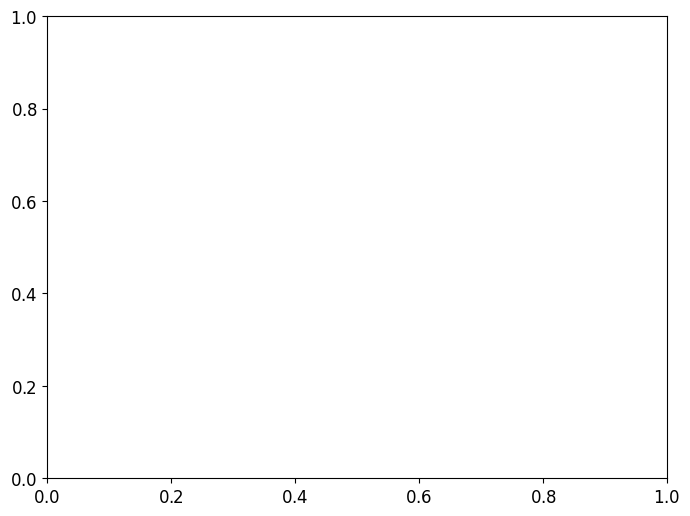

In [38]:
graphWidth = 800
graphHeight = 600

f = plt.figure(figsize=(graphWidth/100.0, graphHeight/100.0), dpi=100)
grafico = f.add_subplot(111)

G - Método 4


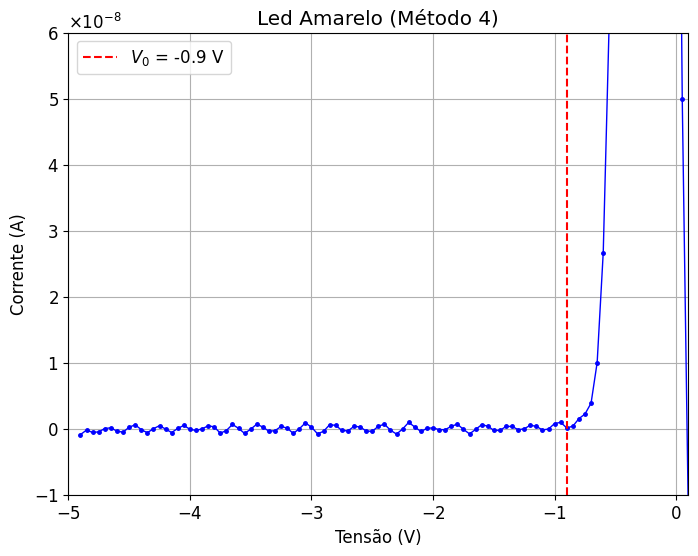

In [39]:

graphWidth = 800
graphHeight = 600

f = plt.figure(figsize=(graphWidth/100.0, graphHeight/100.0), dpi=100)
grafico = f.add_subplot(111)
# plot dos pontos:
grafico3 = grafico.plot(d2x_data, d2y_data, marker = '.', markersize=5, color = 'blue', linewidth = 1)

grafico.axvline(x = V0, color = 'red', label = f'$V_0$ = {V0: .2} V', linestyle = '--')
# grafico.axhline(y = 0, color = 'grey')

plt.xlim(-5, 0.1)
plt.ylim(-10e-9, 6e-8)
grafico.grid(True)
grafico.set_xlabel('Tensão (V)') # eixo x
grafico.set_ylabel('Corrente (A)') # eixo y
grafico.set_title('Led Amarelo (Método 4)') #título
grafico.legend(loc = 'upper left', fontsize= 12)

#    plt.savefig('Acr25graus.png')
plt.show()
